In [ ]:
# TODO:
# Use all encode cell lines for:
# .  - histone mods
# .  - TF binding sites /storage/mgymrek/gtex/tfbs/encodedata/wgEncodeRegTfbsClusteredV3.bed.gz

# Part 2: eSTRs are enriched in putative regulatory regions

This notebook contains:

#### Figures:
* **Figure 2A-D**: Localization
* **Figure 2E**: ChromHMM enrichment
* **Figure 2F**: Motif enrichment and tissue grid

#### Supplementary Figures:
* **Supplementary Figure CAVSCORE**: enrichment in genomic annotations as function of caviar score
* **Supplementary Figure TSSLOC**: strand and motif specific localization
* **Supplementary Figure HISTONE**: enrichment in histone modification 

#### Supplementary Tables:
* **Supplementary Table ANNOTENRICH**: Enrichment in genomic annotations (coding/intron/UTR)
* **Supplementary Table CODINGCAUSAL**: Table of all causal eSTRs in coding regions
* **Supplementary Table TFENRICH**
* **Supplementary Table MOTIFENRICH**

#### Statistics:
* Direction of effect (TODO)


In [1]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-enrich"
FIGPREFIX = "Figure2"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
allstrs = pd.read_csv(os.path.join(DATADIR, "all_analyzed_strs.tab"), sep="\t", names=["chrom","str.start"])

# All ref data
ref = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_annot_v2.bed"), sep="\t")
ref = pd.merge(ref, allstrs, on=["chrom","str.start"])
ref["str.start"] = ref["str.start"]+1

# ChromHMM ref data
ref_chromhmm = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_chromhmm.bed"), sep="\t")
ref_chromhmm["str.start"] = ref_chromhmm["start"]
ref_chromhmm = pd.merge(ref_chromhmm, allstrs, on=["chrom","str.start"])
ref_chromhmm["str.start"] = ref_chromhmm["str.start"]+1

# Histone ref data
ref_hist = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_histone.bed"), sep="\t")
ref_hist["str.start"] = ref_hist["start"]
ref_hist = pd.merge(ref_hist, allstrs, on=["chrom","str.start"])
ref_hist["str.start"] = ref_hist["str.start"]+1

# TF ref data
ref_tf = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_tfbs.bed"), sep="\t")
ref_tf["str.start"] = ref_tf["start"]
ref_tf = pd.merge(ref_tf, allstrs, on=["chrom","str.start"])
ref_tf["str.start"] = ref_tf["str.start"]+1

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions for enrichment calculations

CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal = scipy.stats.fisher_exact(t_causal)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        pval_causal.append(p_causal)

    
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def PlotEnrich(enrich, size=None, fname=None):
    enrich = enrich.sort_values("odds.causal")
    w = 0.4
    fig = plt.figure()
    if size is not None: fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    ax.barh(range(enrich.shape[0]), np.log2(enrich["odds.causal"]), color=CAUSAL_COLOR, height=w)
    ax.barh([item+w for item in range(enrich.shape[0])], np.log2(enrich["odds.estrs"]), color=ESTR_COLOR, height=w)
    ax.set_xlabel("Log2 OR", size=15)
    ax.set_yticks(range(enrich.shape[0]))
    ax.set_yticklabels([item.replace("_", " ") for item in enrich["annot"]], size=12)
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.axvline(x=0, linestyle="dashed", color="gray")
    if fname is not None: fig.savefig(fname)

In [3]:
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

# Supplementary Table ANNOTENRICH
# Supplementary Figure CAVSCORE

In [84]:
all_annot = ["coding", "5utr", "3utr", "intron", "intergenic", "promoter"]

annotenrich_by_cutoff = []
cutoffs = np.arange(0, 0.91, 0.05)
percall = []

for cutoff in cutoffs:
    c = estrs[estrs["score"]>=cutoff]
    percall.append(c.shape[0]*1.0/estrs.shape[0])
    annotenrich_by_cutoff.append(GetEnrichments(ref, estrs, c, all_annot))
    
annotenrich_by_cutoff[list(cutoffs).index(MIN_CAUSAL_SCORE)]

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
0,coding,0.687500,0.466667,16,75,217,4.127908,4.079264,0.210114,0.644464,5.016644e-06,4.007803e-19
1,5utr,0.571429,0.512690,56,197,657,4.879612,3.321041,0.349682,0.775739,2.802536e-20,1.896931e-37
2,3utr,0.510000,0.502137,100,468,1660,3.383690,3.071974,0.920411,0.963137,2.607018e-23,3.130247e-77
3,intron,0.514497,0.504364,1759,10998,74501,1.529178,1.735601,0.233186,0.365004,1.064510e-33,1.453860e-294
4,intergenic,0.487205,0.498606,1016,6458,91325,0.397191,0.390641,0.432867,0.832465,2.460016e-142,0.000000e+00
5,promoter,0.513158,0.485832,380,1941,6866,3.288487,3.252439,0.644361,0.220305,7.935383e-77,0.000000e+00


0.13591017565822933


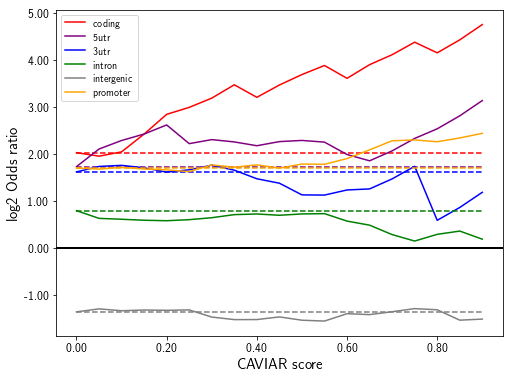

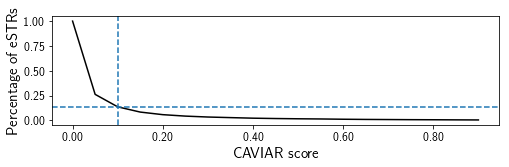

In [86]:
annot_colors = {
    "coding": "red",
    "intron": "green",
    "5utr": "purple",
    "3utr": "blue",
    "intergenic": "gray",
    "promoter": "orange"
}
fig = plt.figure()
fig.set_size_inches((8, 6))
ax = fig.add_subplot(111)
for j in range(len(all_annot)):
    causal_enrich = np.log2([annotenrich_by_cutoff[i]["odds.causal"].values[j] for i in range(len(annotenrich_by_cutoff))])
    estr_enrich = np.log2([annotenrich_by_cutoff[i]["odds.estrs"].values[j] for i in range(len(annotenrich_by_cutoff))])
    color = annot_colors[all_annot[j]]
    ax.plot(cutoffs, causal_enrich, label=all_annot[j], color=color)
    ax.plot(cutoffs, estr_enrich, linestyle="dashed", color=color)
    ax.axhline(y=0, color="black")
ax.legend(loc="upper left");
ax.set_xlabel("CAVIAR score", size=15)
ax.set_ylabel("log2 Odds ratio", size=15)
ax.set_xticklabels(["%.2f"% item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_A.pdf"))

fig = plt.figure()
fig.set_size_inches((8, 2))
ax = fig.add_subplot(111)
ax.plot(cutoffs, percall, color="black")
ax.set_xlabel("CAVIAR score", size=15)
ax.set_ylabel("Percentage of eSTRs", size=15)
ax.set_xticklabels(["%.2f"% item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);
ax.axhline(y=percall[list(cutoffs).index(MIN_CAUSAL_SCORE)], linestyle="dashed")
ax.axvline(x=MIN_CAUSAL_SCORE, linestyle="dashed")
print(percall[list(cutoffs).index(MIN_CAUSAL_SCORE)])
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_B.pdf"))

# Supplementary Table CODINGCAUSAL

In [10]:
coding_causal = pd.merge(causal, ref[ref["coding"]>0][["chrom","str.start"]], on=["chrom","str.start"])[["chrom","str.start","gene.name","motif","score","tissue_info"]]
for item in list(coding_causal["tissue_info"]):
    print(item)
coding_causal

Thyroid_-0.42_1.00;Esophagus-Muscularis_-0.32_0.00;Muscle-Skeletal_-0.40_1.00;Lung_-0.27_0.00;Brain-Caudate_-0.46_0.17;Cells-Transformedfibroblasts_-0.38_0.00;Adipose-Subcutaneous_-0.35_0.91;Nerve-Tibial_-0.41_0.91;Artery-Tibial_-0.31_0.00;Heart-LeftVentricle_-0.33_0.03;Brain-Cerebellum_-0.47_0.49;Adipose-Visceral_-0.26_0.00
Cells-Transformedfibroblasts_0.36_1.00;Nerve-Tibial_-0.21_0.14
Esophagus-Muscularis_-0.28_0.71;Muscle-Skeletal_-0.20_0.13;Adipose-Subcutaneous_-0.28_0.90;Nerve-Tibial_-0.32_0.99;Artery-Tibial_-0.28_0.95
Artery-Aorta_0.25_0.16;Thyroid_0.27_0.79;Cells-Transformedfibroblasts_0.21_0.10;Nerve-Tibial_0.26_0.62
Muscle-Skeletal_0.35_0.59;Adipose-Subcutaneous_0.28_0.06;Nerve-Tibial_0.32_0.03;Artery-Tibial_0.26_0.47
Thyroid_-0.32_0.01;Esophagus-Mucosa_-0.29_0.14;Cells-Transformedfibroblasts_-0.37_0.58;Adipose-Subcutaneous_-0.20_0.04;Nerve-Tibial_-0.22_0.05;Artery-Tibial_-0.28_0.18;Heart-LeftVentricle_-0.25_0.02;WholeBlood_-0.24_0.15;Adipose-Visceral_-0.28_0.01
Thyroid_0.33_0

,chrom,str.start,gene.name,motif,score,tissue_info
0,chr14,24769851,DHRS1,CCT,0.998004,Thyroid_-0.42_1.00;Esophagus-Muscularis_-0.32_...
1,chr9,88356816,AGTPBP1,CCG,0.997629,Cells-Transformedfibroblasts_0.36_1.00;Nerve-T...
2,chr3,40503522,RPL14,CTG,0.988014,Esophagus-Muscularis_-0.28_0.71;Muscle-Skeleta...
3,chr11,6411932,SMPD1,CGCTGG,0.793943,Artery-Aorta_0.25_0.16;Thyroid_0.27_0.79;Cells...
4,chr2,25384461,POMC,AGC,0.589273,Muscle-Skeletal_0.35_0.59;Adipose-Subcutaneous...
5,chr19,55790888,HSPBP1,CGG,0.580568,Thyroid_-0.32_0.01;Esophagus-Mucosa_-0.29_0.14...
6,chr11,124750441,ROBO3,AGCCGG,0.392606,Thyroid_0.33_0.39;Esophagus-Mucosa_0.21_0.01;C...
7,chr3,184429135,MAGEF1,AGG,0.380752,Thyroid_-0.33_0.38;Esophagus-Muscularis_-0.35_...
8,chr19,50093219,PRR12,ACCCCC,0.361102,Esophagus-Mucosa_0.46_0.00;Skin-NotSunExposed_...
9,chr19,11558342,EPOR,CCT,0.286344,Heart-LeftVentricle_0.28_0.29


# Figure 2E CHROMSTATES

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
10,Heterochrom,0.495431,0.501651,1970,13021,150499,0.228420,0.234401,0.701719,0.712825,4.568635e-318,0.000000e+00
9,Insulator,0.325581,0.431298,43,262,1724,1.325877,1.385206,0.031539,0.030399,7.536709e-02,3.483794e-06
6,Repressed,0.511673,0.502499,514,3001,20807,1.365097,1.350227,0.627585,0.798295,5.421172e-10,7.900075e-43
7,Repetitive,0.647059,0.526882,17,93,548,1.657510,1.576856,0.332306,0.678532,5.667477e-02,1.254265e-04
2,Weak_Enhancer,0.497076,0.504326,513,2774,15863,1.859239,1.733259,0.929648,0.662343,1.504613e-32,1.587357e-121
8,Poised_Promoter,0.687500,0.535565,48,239,1333,1.943620,1.690744,0.013283,0.300679,4.395915e-05,4.038007e-12
5,Strong_Enhancer,0.504762,0.498162,210,1088,5261,2.225492,2.065588,0.945006,0.927537,3.397551e-23,4.675839e-84
0,Weak_Txn,0.516560,0.502985,1721,10386,53913,2.457825,2.729963,0.177035,0.549470,7.686434e-142,0.000000e+00
4,Txn_Transition,0.508380,0.481143,179,875,3420,2.959009,2.722789,0.881223,0.279335,4.376142e-33,1.250654e-117
3,Txn_Elongation,0.516820,0.494218,654,3632,12191,3.400849,3.767331,0.411572,0.496309,1.729156e-130,0.000000e+00


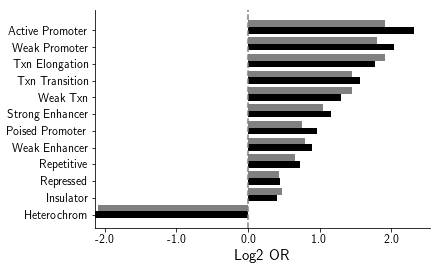

In [4]:
hmm_annot = [item for item in ref_chromhmm.columns if item not in ["chrom","start","end","period","motif","str.start"]]
hmm_enrich = GetEnrichments(ref_chromhmm, estrs, causal, hmm_annot, annot_col=False)
hmm_enrich = hmm_enrich.sort_values("odds.causal", ascending=True)

if SAVEPLOT:
    fname = os.path.join(RESULTSDIR, "%s_chromHMM.pdf"%FIGPREFIX)
PlotEnrich(hmm_enrich, fname=fname)
hmm_enrich

# Supplementary Figure HISTONE

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
5,H3k9me3,0.488439,0.496781,1038,6679,77453,0.566635,0.591238,0.475315,0.607313,3.977449e-54,6.848242e-252
7,H3k27me3,0.505948,0.498677,1429,8691,72202,1.075799,1.094859,0.672123,0.813445,3.915518e-02,2.317125e-09
3,Ctcf,0.529900,0.508134,602,3381,19469,1.791882,1.743374,0.153667,0.353051,3.069754e-33,5.922174e-147
6,H3k27ac,0.530695,0.503550,1238,6760,40546,1.999012,1.814357,0.033000,0.567567,1.318554e-75,1.205972e-282
0,H3k4me1,0.520192,0.508549,1461,8188,48044,2.106287,1.981205,0.129135,0.124503,6.204368e-94,0.000000e+00
4,H3k9ac,0.526460,0.505789,1096,5787,32909,2.163222,1.902733,0.085069,0.385618,7.540213e-86,5.265805e-294
10,H4k20me1,0.521008,0.499842,2142,12628,77979,2.289663,2.309280,0.054454,0.978702,1.197876e-119,0.000000e+00
2,H3k4me3,0.532097,0.514471,701,3697,18270,2.344912,2.168325,0.096472,0.081261,1.008904e-73,4.226865e-288
9,H3k79me2,0.503571,0.501024,1120,6349,30711,2.440537,2.470907,0.834331,0.880292,1.538012e-113,0.000000e+00
1,H3k4me2,0.511737,0.512802,852,4218,20410,2.681370,2.272915,0.515116,0.099440,1.418444e-111,0.000000e+00


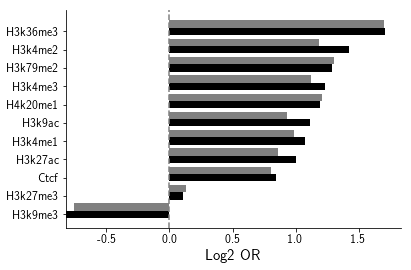

In [5]:
hist_annot = [item for item in ref_hist.columns if item not in ["chrom","start","end","period","motif","str.start"]]
hist_enrich = GetEnrichments(ref_hist, estrs, causal, hist_annot, annot_col=False)
hist_enrich = hist_enrich.sort_values("odds.causal", ascending=True)

if SAVEPLOT:
    fname = os.path.join(RESULTSDIR, "%s_Histone.pdf"%FIGPREFIX)

PlotEnrich(hist_enrich, fname=fname)
hist_enrich

# Supplementary Table TFENRICH

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars


,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs,signif
69,KDM5A,0.500000,0.500000,6,8,13,44.364950,12.327209,1.000000,1.000000,7.138035e-08,2.285750e-05,True
105,RDBP,0.333333,0.200000,3,5,9,25.856348,9.629259,1.000000,0.375000,5.272398e-04,1.691093e-03,False
145,THAP1,0.666667,0.736842,6,19,32,11.943089,11.266007,0.687500,0.063568,2.766221e-05,1.082044e-10,True
112,SAP30,0.629630,0.472222,27,72,170,9.827107,5.675103,0.247789,0.723948,3.752038e-17,2.003560e-24,True
117,SIX5,0.533333,0.523810,15,42,99,9.263662,5.684703,1.000000,0.877614,7.015670e-10,6.300074e-15,True
94,PHF8,0.617647,0.550505,68,198,462,9.082494,5.823700,0.068119,0.176780,1.048858e-38,2.416692e-65,True
31,ELK4,0.733333,0.652174,15,46,111,8.105139,5.460619,0.118469,0.054076,3.578815e-09,9.850348e-16,True
91,NRF1,0.529412,0.531915,17,47,127,8.020909,4.532991,1.000000,0.770867,3.852683e-10,7.962900e-14,True
70,KDM5B,0.523810,0.540146,42,137,321,7.864618,5.766844,0.877614,0.392988,1.791106e-22,1.835114e-45,True
127,SREBP1,0.400000,0.588235,5,17,38,7.838743,6.239127,1.000000,0.629059,7.330528e-04,2.758671e-07,False


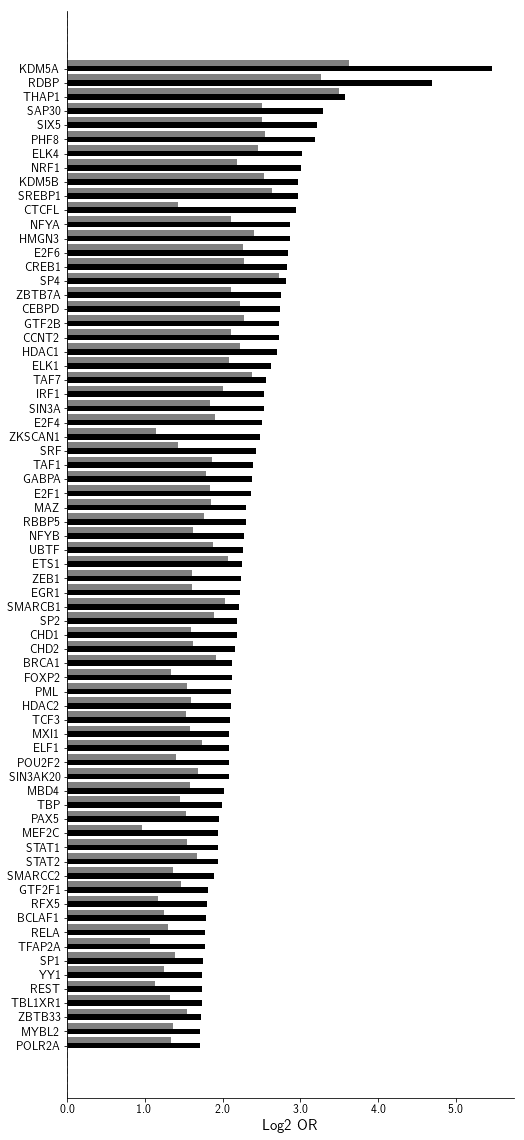

In [24]:
tf_annot = [item for item in ref_tf.columns if item not in ["chrom","start","end","period","motif","str.start"]]
tf_enrich = GetEnrichments(ref_tf, estrs, causal, tf_annot, annot_col=False)
tf_enrich = tf_enrich[tf_enrich["num.causal"]>=3].sort_values("odds.causal", ascending=False)
tf_enrich["signif"] = tf_enrich["pval.causal"]<=0.05/tf_enrich.shape[0]

if SAVEPLOT:
    fname = os.path.join(RESULTSDIR, "%s_TFEnrich.pdf"%FIGPREFIX)
PlotEnrich(tf_enrich.sort_values("odds.causal", ascending=False).head(n=70), size=(8, 20), fname=fname)

#pd.merge(causal, ref_tf[ref_tf["TARDBP"]>0][["chrom","str.start","motif"]], on=["chrom","str.start"])
tf_enrich.sort_values("odds.causal", ascending=False)
OutputEnrichmentTable(tf_enrich, os.path.join(RESULTSDIR, "SuppTable_TFEnrich.csv"))

# Figure 2F: Motifs

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in double_scalars


(0.7450681231925815, 0.0005991851491727926)
0.0013157894736842105
17       AAAT
49         AC
72         AG
84     AGCCCC
95         AT
103    CCCCCG
104     CCCCG
108       CCG
Name: annot, dtype: object


,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs,perc.causal
107,CCCGG,1.000000,0.857143,3,7,13,15.513448,8.988086,0.250000,0.125000,1.695835e-03,2.410721e-04,0.428571
104,CCCCG,0.666667,0.555556,9,18,41,14.568292,6.031910,0.507812,0.814529,6.422837e-08,1.754862e-07,0.500000
103,CCCCCG,0.500000,0.636364,4,11,24,10.344809,6.519833,1.000000,0.548828,1.017315e-03,2.728228e-05,0.363636
89,AGGCGG,1.000000,0.625000,3,8,18,10.341998,6.163406,0.250000,0.726563,4.507727e-03,4.562470e-04,0.375000
84,AGCCCC,0.800000,0.636364,5,11,35,8.622767,3.531326,0.375000,0.548828,4.969502e-04,1.370781e-03,0.454545
105,CCCCGG,1.000000,0.636364,3,11,23,7.756273,7.063198,0.250000,0.548828,9.117856e-03,1.649628e-05,0.272727
108,CCG,0.590909,0.575758,22,66,210,6.079831,3.538262,0.523467,0.267812,1.436869e-10,1.036650e-14,0.333333
2,AAAAAG,0.727273,0.589744,11,39,213,2.819613,1.727651,0.226563,0.336784,2.751030e-03,3.443133e-03,0.282051
81,AGC,0.400000,0.345455,10,55,293,1.828209,1.781939,0.753906,0.030029,7.937480e-02,3.093271e-04,0.181818
44,AATC,0.666667,0.604167,9,48,271,1.776952,1.659335,0.507812,0.193413,1.104379e-01,2.214263e-03,0.187500


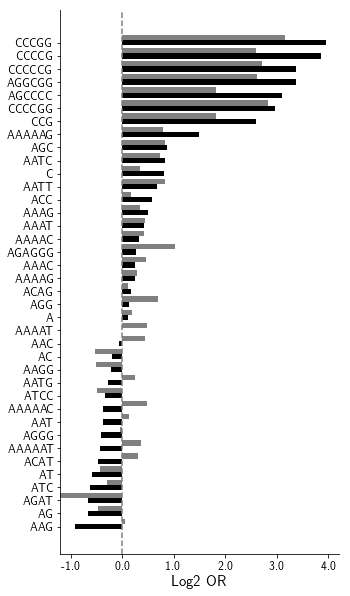

In [12]:
motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
motifs = motifs[motifs["motif"] != "ACACAC"]
motifs = list(motifs[motifs["str.start"]>=10]["motif"])
ref_motif = ref[["chrom","str.start","motif"]].copy()
ref_motif["annot"] = ref_motif["motif"]
motif_enrich = GetEnrichments(ref_motif, estrs, causal, motifs, annot_col=True)
motif_enrich = motif_enrich[motif_enrich["num.causal"]>=3]

# Interesting relationship between odds ratio and perc positive
d = motif_enrich
x = d[d["pval.causal"]<=0.05]
print(scipy.stats.pearsonr(np.log2(x["odds.causal"]), x["dir.causal"]))

if SAVEPLOT:
    fname = os.path.join(RESULTSDIR, "%s_Motif.pdf"%FIGPREFIX)
PlotEnrich(motif_enrich, size=(5, 10), fname=fname)
motif_enrich["perc.causal"] = motif_enrich["num.causal"]*1.0/motif_enrich["num.estrs"]

# P-value levels for causal
for p in [0.05/motif_enrich.shape[0]]:
    print(p)
    print(motif_enrich[motif_enrich["pval.causal"]<=p]["annot"])
motif_enrich = motif_enrich.sort_values("odds.causal", ascending=False)
motif_enrich
OutputEnrichmentTable(motif_enrich, os.path.join(RESULTSDIR, "SuppTable_MotifEnrich.csv"))

# Figure 2B: Motif tissue grid

In [5]:
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
}
TISSUES = COLORS.keys()

master = {} # Map of tissue -> master data. Include all loci for comparisons below
for t in TISSUES:
    df = pd.read_csv(os.path.join(BASEDATADIR, "eSTR-calling", "%s_MasterTable.tab"%t), sep="\t")
    df = df[~np.isnan(df["best.str.start"])]
    df["gene"] = df["gene"].apply(lambda x: x.split(".")[0])
    df["significant"] = (df["significant"]==1)
    df["signif_%s"%t] = df["significant"]
    master[t] = df 

In [6]:
all_motifs = list(motif_enrich["annot"])

motif_enrich_all = {}
for t in TISSUES:
    print(t)
    tdata = master[t].copy()
    tdata["annot"] = tdata["motif"]
    tdata["is.estr"] =(tdata["best.str"]==1) & (tdata["qvalue"]<=MINQ)
    motif_enrich_all[t] = GetEnrichments(tdata[["chrom","str.start","annot"]].drop_duplicates(), tdata[tdata["is.estr"]].copy(), tdata[tdata["is.estr"] & (tdata["caviar.score"]<=MIN_CAUSAL_SCORE)].copy(),
                                    all_motifs, annot_col = True)

Cells-Transformedfibroblasts


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:66: RuntimeWarning: invalid value encountered in double_scalars


Lung


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in double_scalars


Adipose-Visceral
Esophagus-Muscularis
Skin-SunExposed
Thyroid
Esophagus-Mucosa
Artery-Aorta
Brain-Caudate
Brain-Cerebellum
Artery-Tibial
Muscle-Skeletal
Nerve-Tibial
Skin-NotSunExposed
Heart-LeftVentricle
WholeBlood
Adipose-Subcutaneous


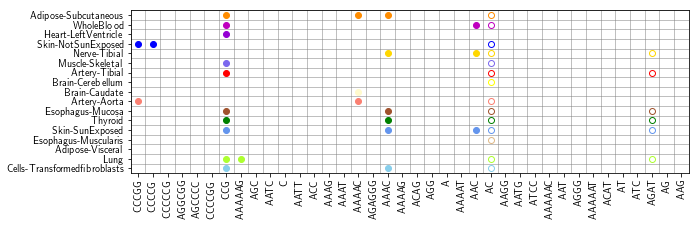

In [17]:
pthresh = 0.05/len(all_motifs)

fig = plt.figure()
fig.set_size_inches((10, 3))

ax = fig.add_subplot(111)

yval = 0
all_motifs = list(motif_enrich["annot"])
for t in TISSUES:
    ax.axhline(y=yval-0.5, color="gray", linewidth=0.5)
    x = motif_enrich_all[t]
    pvals = [x[x["annot"]==m]["pval.causal"].values[0] for m in all_motifs]
    dirs = [x[x["annot"]==m]["odds.causal"].values[0] for m in all_motifs]
    pvals = [item<pthresh for item in pvals]
    dirs = [item>1 for item in dirs]
    for i in range(len(pvals)):
        if pvals[i]:
            if dirs[i]:
                ax.scatter([i], [yval], color=COLORS[t], marker="o")
            else: ax.scatter([i], [yval], color="white", edgecolor=COLORS[t], marker="o")
    yval += 1
ax.axhline(y=yval-0.5, color="gray", linewidth=0.5)
for xval in range(len(all_motifs)+1):
    ax.axvline(x=xval-0.5, color="gray", linewidth=0.5)
ax.set_xticks(range(len(all_motifs)))
ax.set_xticklabels(all_motifs, rotation=90);
ax.set_yticks(range(len(TISSUES)))
ax.set_yticklabels(TISSUES);
ax.set_xlim(left=-0.5, right=len(all_motifs)-0.5);
ax.set_ylim(bottom=-0.5, top=len(TISSUES)-0.5);

if SAVEPLOT:
    fname = os.path.join(RESULTSDIR, "%s_MotifGrid.pdf"%FIGPREFIX)
    fig.savefig(fname)

# Direction of effect

In [259]:
print("all estrs")
print(sum(estrs["beta"]>0)*1.0/estrs.shape[0])
print(scipy.stats.binom_test(sum(estrs["beta"]>0), estrs.shape[0]))
print("causal estrs")
print(sum(causal["beta"]>0)*1.0/causal.shape[0])
print(scipy.stats.binom_test(sum(causal["beta"]>0), causal.shape[0]))

print("enriched motifs causal enriched for pos effect sizes")
enriched_motifs = list(motif_enrich[(motif_enrich["pval.causal"]<=0.05/motif_enrich.shape[0]) & (motif_enrich["odds.causal"]>1)]["annot"])
x = causal[causal["motif"].apply(lambda x: x in enriched_motifs)]
print(sum(x["beta"]>0)*1.0/ x.shape[0])
print(scipy.stats.binom_test(sum(x["beta"]>0), x.shape[0], alternative="greater"))

all estrs
0.5034623058565784
0.2709664693644683
causal estrs
0.5086355785837651
0.3168234161828592
enriched motifs causal enriched for pos effect sizes
0.6062992125984252
0.010340392009458764


# Figure 2A-D, Supplementary Figure TSSLOC: Localization

In [11]:
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"]
hipmotif = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","period","motif_pos","motif_neg"])
dnaseI = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])

all_str_genes = pd.read_csv(os.path.join(DATADIR, "all_analyzed_estrs.tab"), sep="\t", names=["chrom","str.start","gene"])
all_str_genes = pd.merge(all_str_genes, geneannot[["gene","gene.start","gene.stop","gene.strand"]], on=["gene"])
all_str_genes = pd.merge(all_str_genes, hipmotif[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])
all_str_genes["dist.tss"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["dist.tes"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="-" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["motif"] = all_str_genes.apply(lambda x: x["motif_pos"] if x["gene.strand"]=="+" else x["motif_neg"], 1)
all_str_genes = pd.merge(all_str_genes, dnaseI[["chrom","str.start","dist.dnase"]], on=["chrom","str.start"])
all_str_genes["gene"] = all_str_genes["gene"].apply(lambda x: x.split(".")[0])
all_str_genes["str.start"] = all_str_genes["str.start"]+1

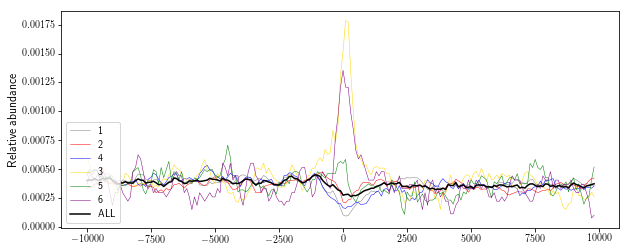

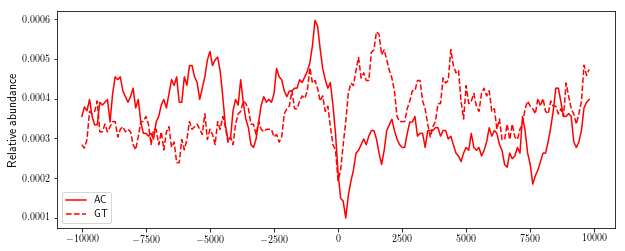

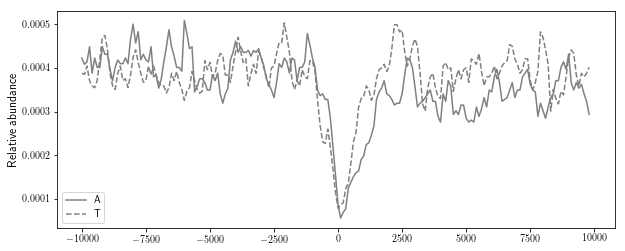

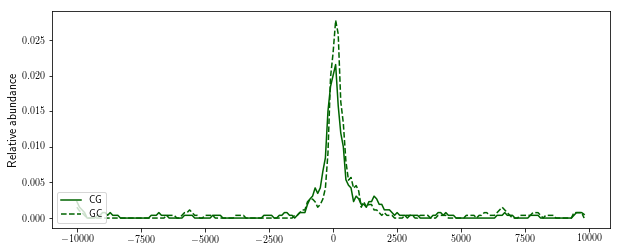

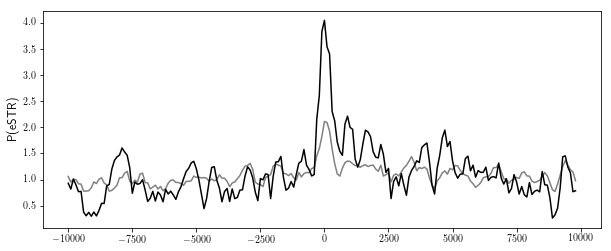

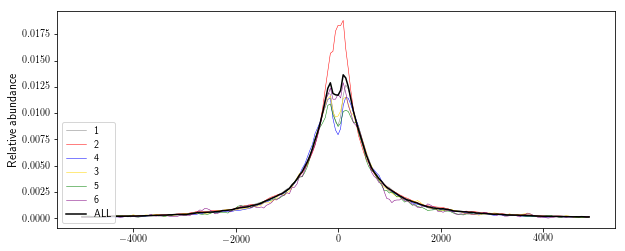

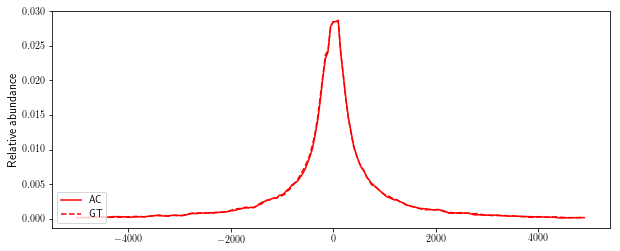

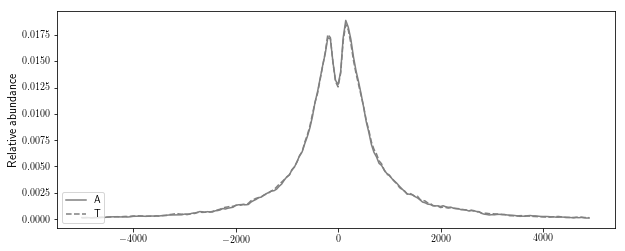

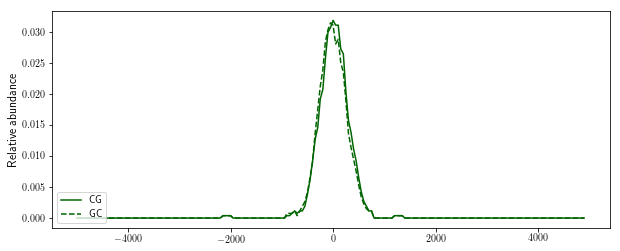

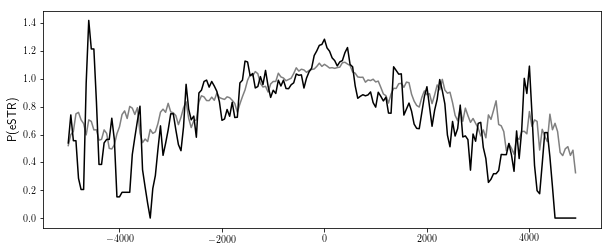

In [16]:
default_bins = np.arange(-50000, 50000, 1000)

def ProcessData(all_str_genes, estrs, causal, col, bins=default_bins):
    #keys = ["ALL","AC","GT","CG","AT","AG","CT","A","T"]
    all_motifs = set(all_str_genes["motif"])
    othermotifs = {
        "AC": ["AC"],
        "GT": ["GT"],
        "AG": ["AG"],
        "CT": ["CT"],
        "CG": ["CG","CCG","CCCG","CCCCG","CCCCCG","CCCCGG"],
        "GC": ["CG", "CGG", "CGGG", "CGGGG", "CGGGGG", "CCGGGG"],
        "AT": ["AT"],
        "AG": ["AG"],
        "AGG": ["AGG"],
        "A": ["A"],
        "T": ["T"],
        "2": [item for item in all_motifs if len(item)==2],
        "1": [item for item in all_motifs if len(item)==1],
        "5": [item for item in all_motifs if len(item)==5],
        "6": [item for item in all_motifs if len(item)==6],
        "4": [item for item in all_motifs if len(item)==4],
        "3": [item for item in all_motifs if len(item)==3],
        "ALL": all_motifs
    }
    keys = othermotifs.keys()
    num = {}
    p = {}
    p_causal = {}
    
    num_total = all_str_genes[["chrom","str.start"]].drop_duplicates().shape[0]
    num_estrs = estrs[["chrom","str.start"]].drop_duplicates().shape[0]
    num_causal = causal[["chrom","str.start"]].drop_duplicates().shape[0]
    p_avg = num_estrs*1.0/num_total
    p_causal_avg = num_causal*1.0/num_total
    
    # Get bindata
    for key in keys:
        num[key] = []
        p[key] = []
        p_causal[key] = []
        
        all_motif_data = all_str_genes[all_str_genes["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        estr_motif_data = estrs[estrs["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        causal_motif_data = causal[causal["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        
        estr_motif_data = pd.merge(all_motif_data, estr_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        causal_motif_data = pd.merge(all_motif_data, causal_motif_data[["chrom","str.start","gene"]], on=["chrom","str.start","gene"])
        
        for i in range(len(bins)-1):
            lb = bins[i]
            ub = bins[i+1]
            x_all = all_motif_data[(all_motif_data[col]>=lb) & (all_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            x_estr = estr_motif_data[(estr_motif_data[col]>=lb) & (estr_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            x_causal = causal_motif_data[(causal_motif_data[col]>=lb) & (causal_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            if x_all == 0:
                num[key].append(0)
                p[key].append(float("nan"))
                p_causal[key].append(float("nan"))
            else:
                num[key].append(x_all*1.0/all_motif_data.shape[0])
                p[key].append(x_estr*1.0/x_all)
                p_causal[key].append(x_causal*1.0/x_all)
    return num, p, p_causal, p_avg, p_causal_avg

def Smooth(x, buf=2, avg=None, norm=False):
    if avg is not None:
        x = [item*1.0/avg for item in x]
    if norm:
        m = np.mean(x)
        x = [item*1.0/m for item in x]
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

def PlotPosition(num, p, p_causal, p_avg, pcausal_avg, bins=default_bins, buf=2, col=None, RESULTSDIR=None):
    colors = {
    "ALL": ("black", "solid"),
    "A": ("gray", "solid"),
    "T": ("gray", "dashed"),
    "AC": ("red", "solid"),
        "GT": ("red", "dashed"),
        "AT": ("maroon", "solid"),
        "1": ("gray", "solid"),
        "2": ("red", "solid"),
        "3": ("gold", "solid"),
        "4": ("blue", "solid"),
        "5": ("green", "solid"),
        "6": ("purple", "solid"),
        "CG": ("darkgreen", "solid"),
        "GC": ("darkgreen", "dashed")
    }
    size = ((10, 4))
    usekeys = colors.keys()
    
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    keys = ["1","2","4","3","5","6", "ALL"]
    for key in keys:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
    ax.set_ylabel("Relative abundance", size=12)
    ax.legend(loc="lower left")
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_num.pdf"%col))
    
    # For supplement, plot strand diffs
    for mp in [("AC","GT"), ("A","T"), ("CG","GC")]:
        fig = plt.figure()
        fig.set_size_inches(size)
        ax2 = fig.add_subplot(111)
        for key in mp:
            ax2.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
            ax2.set_ylabel("Relative abundance", size=12)
        ax2.legend(loc="lower left")
        if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_%s_num_%s.pdf"%(col, mp[0])))

    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    for key in ["ALL"]:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(p[key], avg=p_avg, buf=buf)), color=ESTR_COLOR, linewidth=w, label=key)
        ax.plot(bins[:-1], (Smooth(p_causal[key], avg=p_causal_avg, buf=buf)), color=CAUSAL_COLOR, linewidth=w, label=key)
    ax.set_ylabel("P(eSTR)", size=12)
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure2_%s_peSTR.pdf"%col))

bins = np.arange(-10000, 10000, 100)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, causal, "dist.tss", bins=bins)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.tss", RESULTSDIR=RESULTSDIR)

bins = np.arange(-5000, 5000, 50)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, causal, "dist.dnase", bins=bins)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=2, col="dist.dnase", RESULTSDIR=RESULTSDIR)